**Задание на лабораторную работу.**


Разработать собственную программу на языке Python для определения значений
параметров работы алгоритмов классификации, обеспечивающих минимальное значение
*ошибки второго рода* на заданном наборе данных. Использовать наборы данных, полученные при выполнении лабораторной работы No1. 



**Результаты, которые необходимо получить в итоге:**
1. Значения параметров для классификации с использованием K ближайших
соседей и деревьев решений.
2. Таблицу, содержащую значения F-меры, точности и полноты для каждого класса
при использовании оптимальных значений параметров классификации.
3. Выводы о плюсах и минусах используемых методов поиска оптимальных
параметров.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pylab import rc, plot

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

cmap = sns.diverging_palette(220, 10, as_cmap=True) # цветовая палитра для seaborn 

%matplotlib inline
pd.get_option("display.max_columns")

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot

# <center> Этапы выполнения работы: </center>

1. Генерация и визуализация исходных данных;
2. Формирование функций для GridSearch/RandomSearch;
3. Построение дерева решений;
4. Построение k ближайших соседей;
5. Формирование выводов.

# Генерация данных:

In [2]:
# параметры
N, M, R_min, R_max = 6, 766*6, .722, .735

# Генерация шести классов, каждый из которых представим в виде двух признаков
X, y = make_blobs(n_samples=M, centers=N, n_features=2,
                  cluster_std = 1.85,
                   random_state=0)
 
# first_feature, second_feature - признаки; target_value - метка класса
columns = {'first_feature': X[:, 0], 'second_feature': X[:, 1], 'target_value': y}
data = pd.DataFrame(data = columns)
data.head(10)

,first_feature,second_feature,target_value
0,4.004131,-0.144641,1
1,4.992626,-0.292363,1
2,1.886424,0.154758,1
3,-0.308680,4.026963,0
4,0.931267,2.938430,0
5,-1.136299,2.435678,2
6,-1.267973,5.967928,2
7,1.962615,-0.663025,1
8,8.254345,1.987171,5
9,1.084495,-1.665100,1


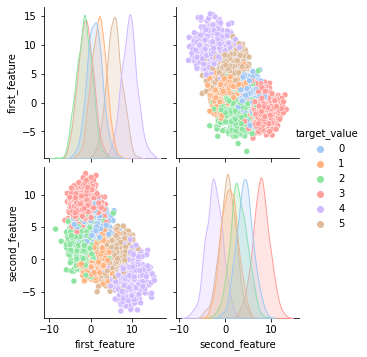

In [3]:
# визуализация данных

g = sns.pairplot(data, hue='target_value', palette='pastel')
g.fig.set_size_inches(5,5)

# Используемые функции:

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [5]:
# параметры для дерева решений
params = dict(max_depth = np.linspace(1, 32, 32, endpoint=True), 
                      min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True),
                      min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
                      )
# признаки и целевая переменная (метка класса)
values, targets = data.drop('target_value', axis=1), data.target_value
# разбиение на train-test 
x_train, x_test, y_train, y_test = train_test_split(data.drop('target_value', axis=1), data.target_value, test_size=0.5, stratify=data.target_value, random_state=42)

In [6]:
# использую refit='recall_macro', так как recall = TP / (TP + FN)
# мне необходимо минимизировать ошибку второго рода (FN)
# чем меньше значение FN, тем больше значение recall
# чем выще recall, тем меньше ложных пропусков -> меньше ошибка второго рода

def do_random_search(model=None, refit='recall_macro', params=params, values=values, tagrets=targets):

    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
    random_search_cv = RandomizedSearchCV(model, params, scoring=['f1_macro','precision_macro', 'recall_macro'], 
                                          n_jobs=4, cv=cv, verbose=3, random_state=42, refit=refit)
    random_search = random_search_cv.fit(values, targets)
    print('Best params for {}'.format(refit))
    print(random_search.best_params_)

In [7]:
def do_grid_search(model=None, refit='recall_macro', params=params, x_train=x_train, y_train=y_train, x_test=x_test):
    
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
    grid_search = GridSearchCV(model, params, scoring=['f1_macro','precision_macro', 'recall_macro'], 
                                n_jobs=4, cv=cv, verbose=3, refit=refit) 
    grid_search.fit(x_train.values, y_train.values)
    y_pred = grid_search.predict(x_test.values)
    print('Best params for {}'.format(refit))
    print(grid_search.best_params_)


In [8]:
def print_result(y_test=y_test, pred=None):
  
  print("classification report: \n", classification_report(y_test, pred))
  conf_matrix = confusion_matrix(y_test, pred)
  print("Матрица ошибок: \n", conf_matrix, "\n")
  sns.heatmap(conf_matrix, cmap = cmap, annot=True)

# Дерево решений:

In [267]:
dtree = DecisionTreeClassifier(random_state=42)
score = cross_val_score(dtree, data.drop('target_value', axis=1), data.target_value, cv=9, scoring='recall_macro')
print('Средняя оценка recall без настройки гиперпараметров: ', np.mean(score))

Средняя оценка recall без настройки гиперпараметров:  0.6162056036885039


classification report: 
               precision    recall  f1-score   support

           0       0.43      0.47      0.45       383
           1       0.49      0.51      0.50       383
           2       0.52      0.53      0.53       383
           3       0.76      0.74      0.75       383
           4       0.84      0.81      0.82       383
           5       0.62      0.57      0.60       383

    accuracy                           0.61      2298
   macro avg       0.61      0.61      0.61      2298
weighted avg       0.61      0.61      0.61      2298

Матрица ошибок: 
 [[179  59  86  50   0   9]
 [ 81 196  51   3   1  51]
 [ 88  52 203  37   0   3]
 [ 56   1  43 283   0   0]
 [  0   2   0   0 310  71]
 [ 13  87   5   0  58 220]] 



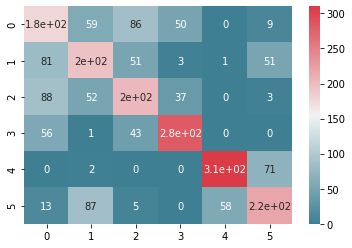

In [10]:
dtree.fit(x_train, y_train)
pred = dtree.predict(x_test)
print_result(y_test=y_test, pred=pred)

## Random search

In [11]:
%%time
do_random_search(model=dtree, refit='recall_macro', params=params, values=values, tagrets=targets)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Best params for recall_macro
{'min_samples_split': 0.01, 'min_samples_leaf': 0.04000000000000001, 'max_depth': 12.0}
CPU times: user 175 ms, sys: 28.1 ms, total: 204 ms
Wall time: 2.15 s


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.1s finished


RandomSearchCV дал следующие значения гиперпараметров: 

**{'min_samples_split': 0.01, 'min_samples_leaf': 0.04000000000000001, 'max_depth': 12.0}**

Затраченное время: 
- CPU times: user 171 ms, sys: 22.1 ms, total: 193 ms
- Wall time: 2.07 s

In [268]:
dtree_random = DecisionTreeClassifier(random_state=42, max_depth=12.0, min_samples_leaf=0.04000000000000001, min_samples_split=0.01)

score = cross_val_score(dtree_random, data.drop('target_value', axis=1), data.target_value, cv=9, scoring='recall_macro')
print('Средняя оценка recall с настройкой гиперпараметров RandomSearch: ', np.mean(score))

Средняя оценка recall с настройкой гиперпараметров RandomSearch:  0.6872295688301161


classification report: 
               precision    recall  f1-score   support

           0       0.62      0.41      0.49       383
           1       0.60      0.76      0.67       383
           2       0.63      0.68      0.66       383
           3       0.81      0.85      0.83       383
           4       0.79      0.94      0.86       383
           5       0.75      0.56      0.64       383

    accuracy                           0.70      2298
   macro avg       0.70      0.70      0.69      2298
weighted avg       0.70      0.70      0.69      2298

Матрица ошибок: 
 [[156  61  88  64   0  14]
 [ 26 292  29   0   4  32]
 [ 46  59 261  15   0   2]
 [ 23   0  33 327   0   0]
 [  0   0   0   0 361  22]
 [  2  74   1   0  92 214]] 



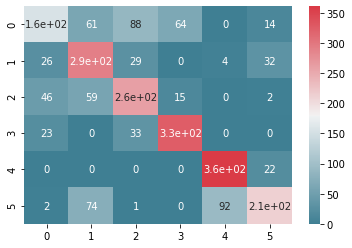

In [13]:
dtree_random.fit(x_train, y_train)
pred_random_search = dtree_random.predict(x_test)
print_result(y_test=y_test, pred=pred_random_search)

Визуализируем дерево решений, полученное с настройкой гиперпараметров RandomSearchCV:

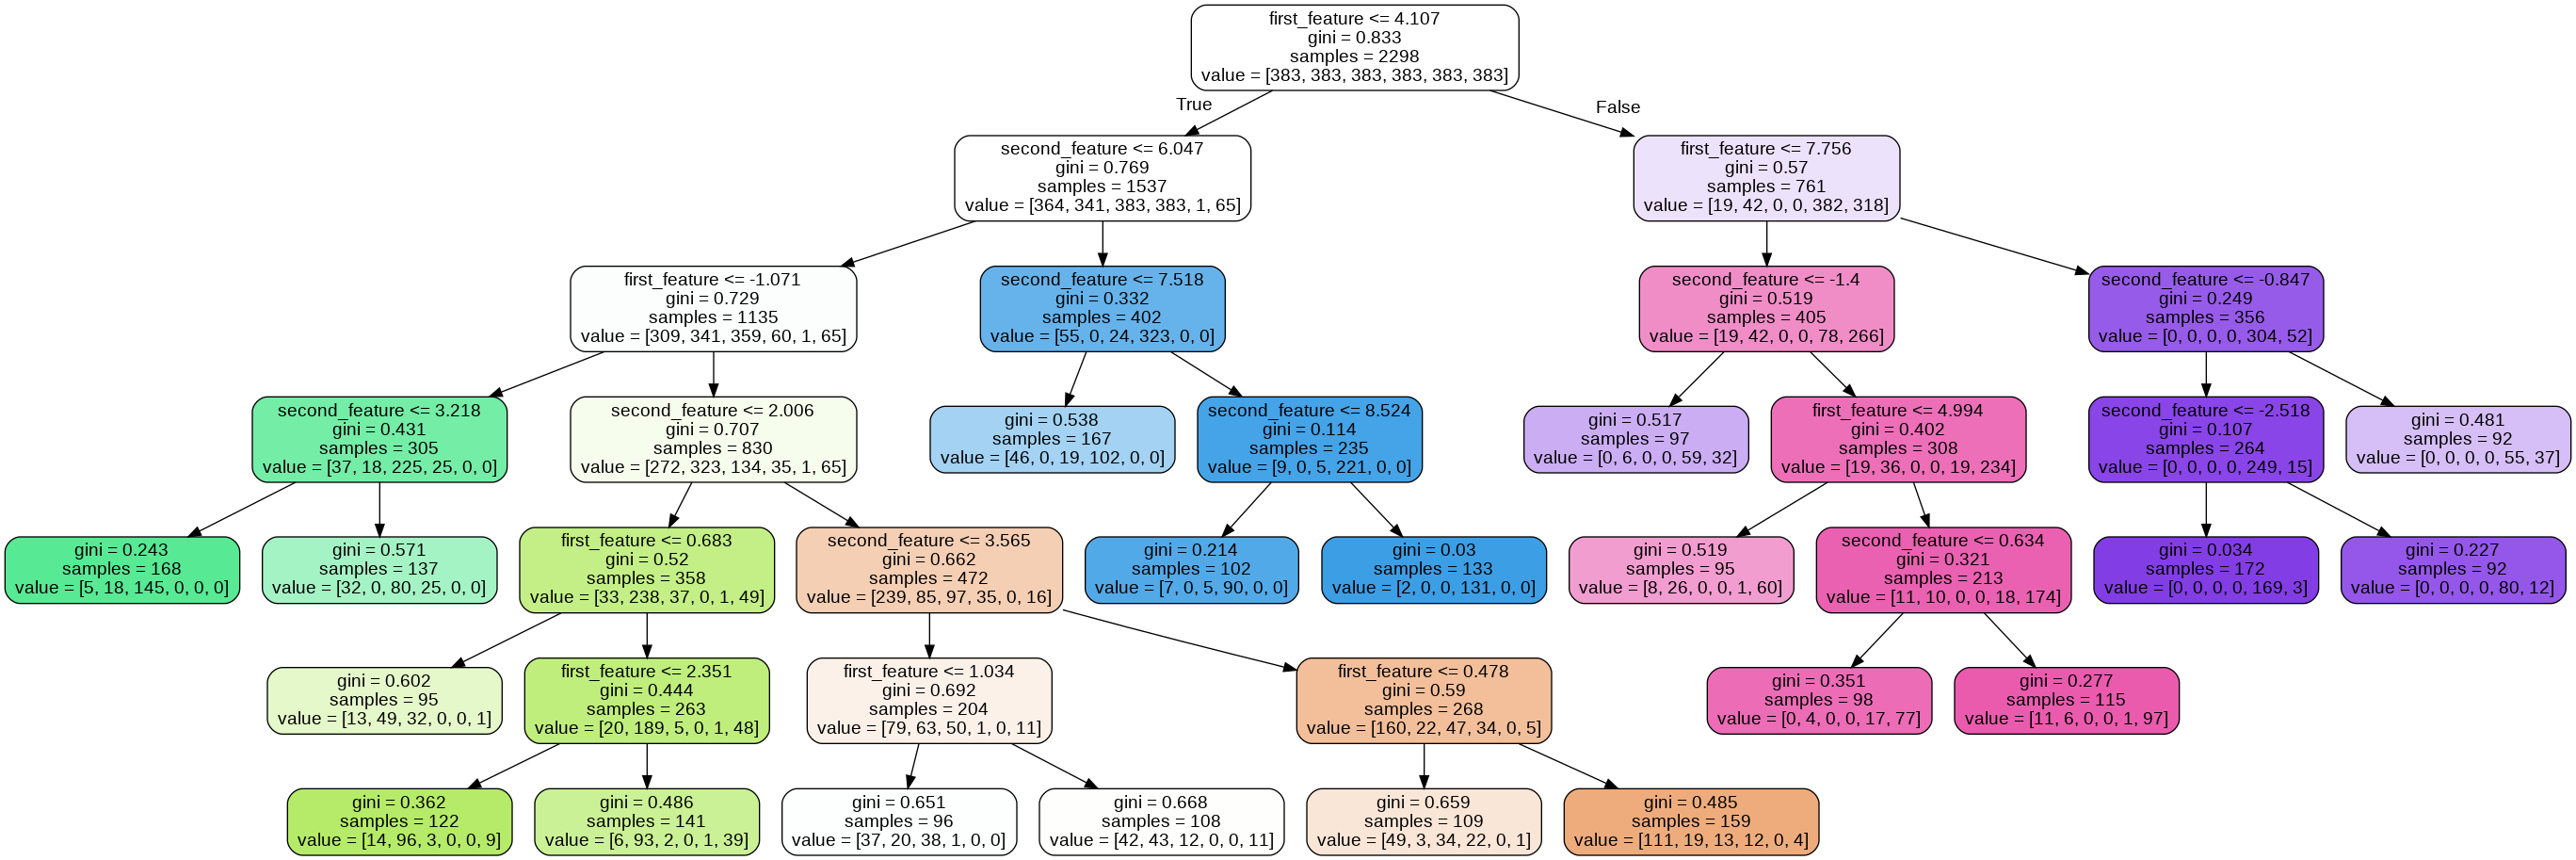

In [14]:
features = list(values.columns)
dot_data = StringIO()
export_graphviz(dtree_random, out_file=dot_data, feature_names=features, filled=True, rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

Дерево решения также иногда используется для отбора информативных признаков. 
Признаки в верхних листьях являются наиболее информативными.
Из визуализации видно, что самый верхний лист соотвествует сравнению признака first_feature с числом, следовательно, признак first_feature важнее признака second_feature.

Проверим, есть ли переобучение при настройке гиперпараметров:

In [269]:
from sklearn.model_selection import validation_curve

max_depth = np.linspace(1, 32, 32, endpoint=True)
train_scores, valid_scores = validation_curve(dtree_random, values, targets, "max_depth",
                                             param_range=max_depth, cv=9, scoring="recall_macro")

In [66]:
def plot_valid_train(train_scores, valid_scores, param):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.plot(param, train_mean, label="Training score", color='black')
    plt.plot(param, valid_scores_mean, label="Cross-validation score", color="dimgrey")

    plt.fill_between(param, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(param, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, color="gainsboro")


    # Create plot
    plt.title("Validation Curve")
    plt.ylabel("Recall Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.show()

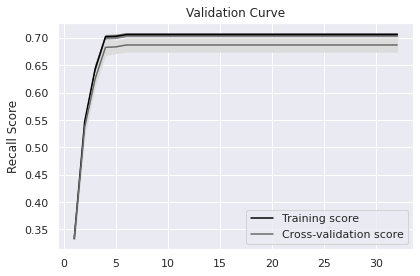

In [270]:
# max_depth
plot_valid_train(train_scores, valid_scores, max_depth)

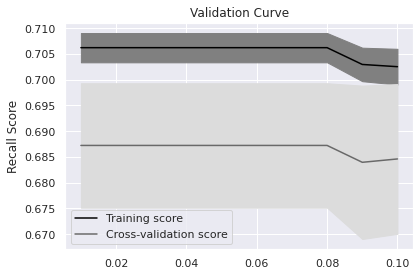

In [272]:
min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True)
train_scores, valid_scores = validation_curve(dtree_random, values, targets, "min_samples_split",
                                             param_range=min_samples_split, cv=9, scoring="recall_macro")
# min_samples_split
plot_valid_train(train_scores, valid_scores, min_samples_split)

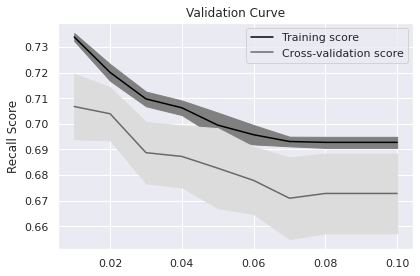

In [273]:
min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
train_scores, valid_scores = validation_curve(dtree_random, values, targets, "min_samples_leaf",
                                             param_range=min_samples_leaf, cv=9, scoring="recall_macro")
# min_samples_split
plot_valid_train(train_scores, valid_scores, min_samples_leaf)

На всех графиках видно, что прямые примерно параллельны, также ошибка на train всегда меньше, чем в результате CV, но большой разницы между ними  нет (~0.05 в среднем).
Можно утверждать, что переобучения нет.

Также на графиках видно, какие примерные значения параметров являются оптимальными.

## Grid search:

In [15]:
%%time
do_grid_search(model=dtree, refit='recall_macro', params=params, x_train=x_train, y_train=y_train, x_test=x_test)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 2904 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done 8024 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 15192 tasks      | elapsed:   49.3s


Best params for recall_macro
{'max_depth': 6.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.030000000000000006}
CPU times: user 7.45 s, sys: 103 ms, total: 7.55 s
Wall time: 51.8 s


[Parallel(n_jobs=4)]: Done 16000 out of 16000 | elapsed:   51.7s finished


GridSearchCV дал следующие значения гиперпараметров:

**{'max_depth': 6.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.030000000000000006}**

Затраченное время:
- CPU times: user 8.57 s, sys: 194 ms, total: 8.76 s
- Wall time: 53.6 s

In [274]:
dtree_grid = DecisionTreeClassifier(random_state=42, max_depth=6.0, min_samples_leaf=0.01, min_samples_split=0.030000000000000006)

score = cross_val_score(dtree_grid, values, targets, cv=9, scoring='recall_macro')
print('Средняя оценка recall с настройкой гиперпараметров GridSearch: ', np.mean(score))

Средняя оценка recall с настройкой гиперпараметров GridSearch:  0.7043446319096114


classification report: 
               precision    recall  f1-score   support

           0       0.56      0.51      0.53       383
           1       0.62      0.63      0.63       383
           2       0.57      0.70      0.63       383
           3       0.84      0.81      0.82       383
           4       0.90      0.86      0.88       383
           5       0.74      0.68      0.71       383

    accuracy                           0.70      2298
   macro avg       0.70      0.70      0.70      2298
weighted avg       0.70      0.70      0.70      2298

Матрица ошибок: 
 [[194  44  97  45   0   3]
 [ 31 243  76   0   0  33]
 [ 66  33 268  15   0   1]
 [ 43   0  30 310   0   0]
 [  0   0   0   0 328  55]
 [ 12  74   1   0  35 261]] 



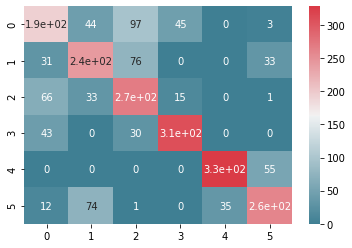

In [17]:
dtree_grid.fit(x_train, y_train)
pred_grid_search = dtree_grid.predict(x_test)
print_result(y_test, pred_grid_search)

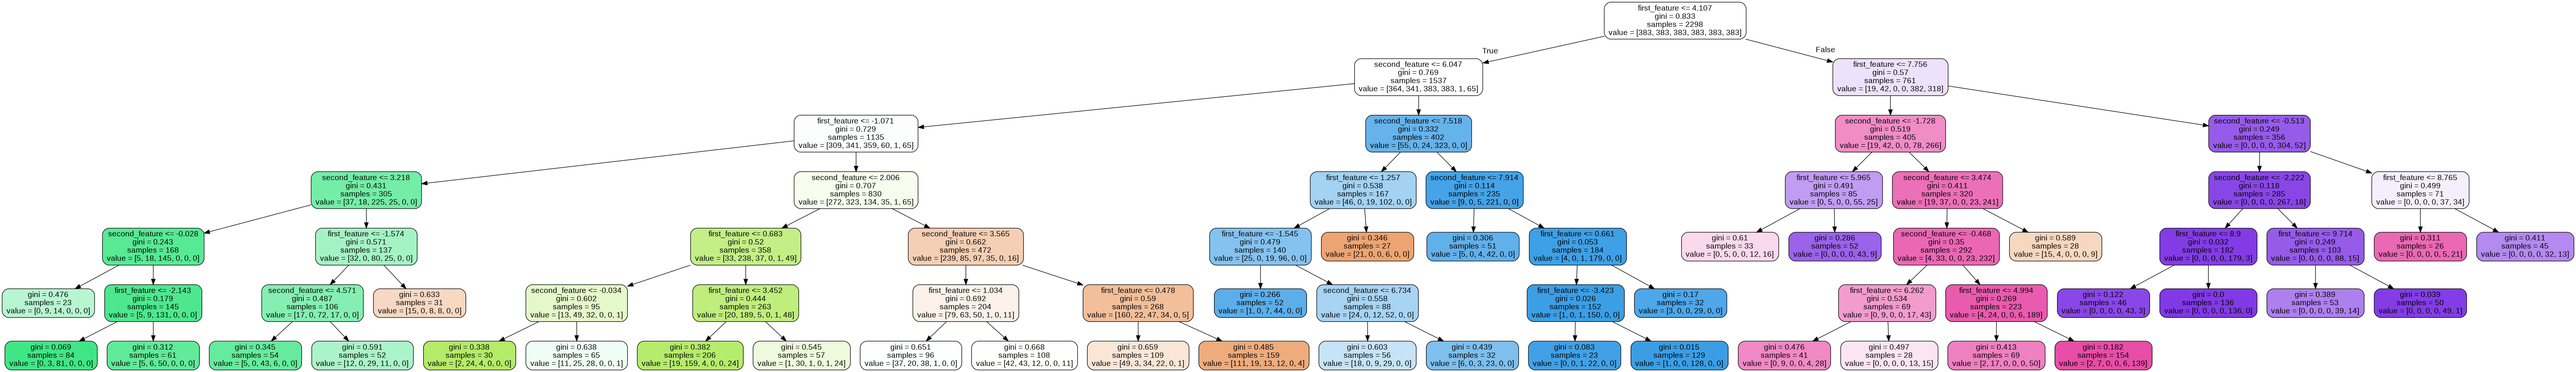

In [18]:
features = list(values.columns)
dot_data = StringIO()
export_graphviz(dtree_grid, out_file=dot_data, feature_names=features, filled=True, rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

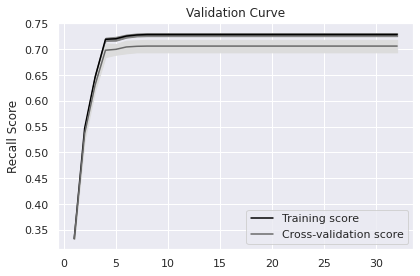

In [275]:
train_scores, valid_scores = validation_curve(dtree_grid, values, targets, "max_depth",
                                             param_range=max_depth, cv=9, scoring="recall_macro")
# max_depth
plot_valid_train(train_scores, valid_scores, max_depth)

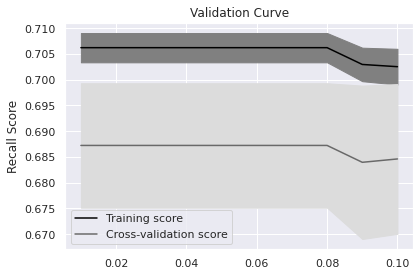

In [276]:
train_scores, valid_scores = validation_curve(dtree_random, values, targets, "min_samples_split",
                                             param_range=min_samples_split, cv=9, scoring="recall_macro")
# min_samples_split
plot_valid_train(train_scores, valid_scores, min_samples_split)

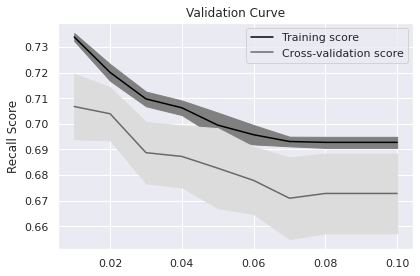

In [277]:
train_scores, valid_scores = validation_curve(dtree_random, values, targets, "min_samples_leaf",
                                             param_range=min_samples_leaf, cv=9, scoring="recall_macro")
# min_samples_split
plot_valid_train(train_scores, valid_scores, min_samples_leaf)

Здесь графики похожи на графики случайного поиска.

Переобучение не наблюдается.

# kNN

In [278]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred_knn = knn.predict(x_test)

score = cross_val_score(knn, values, targets, cv=9, scoring='recall_macro')
print('Средняя оценка recall без настройки гиперпараметров: ', np.mean(score))

Средняя оценка recall без настройки гиперпараметров:  0.6782261741906065


classification report: 
               precision    recall  f1-score   support

           0       0.49      0.57      0.53       383
           1       0.56      0.62      0.59       383
           2       0.62      0.59      0.60       383
           3       0.84      0.80      0.82       383
           4       0.91      0.87      0.89       383
           5       0.73      0.64      0.68       383

    accuracy                           0.68      2298
   macro avg       0.69      0.68      0.68      2298
weighted avg       0.69      0.68      0.68      2298

Матрица ошибок: 
 [[217  50  68  44   0   4]
 [ 72 238  36   0   0  37]
 [ 92  49 225  15   0   2]
 [ 44   1  32 306   0   0]
 [  0   0   0   0 334  49]
 [ 17  86   0   0  35 245]] 



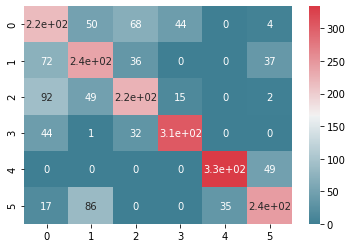

In [20]:
print_result(y_test, pred_knn)

## Random search:

In [82]:
# параметры для kNN
params = dict(n_neighbors = np.array(range(1, 15, 1)), 
              weights = ['uniform', 'distance'],
              algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'], 
              p = [1, 2],
              metric = ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'seuclidean', 'mahalanobis']
              )

In [83]:
%%time
do_random_search(model=knn, refit='recall_macro', params=params, values=values, tagrets=targets)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.7s


Best params for recall_macro
{'weights': 'uniform', 'p': 1, 'n_neighbors': 10, 'metric': 'minkowski', 'algorithm': 'brute'}
CPU times: user 186 ms, sys: 33.9 ms, total: 220 ms
Wall time: 3.35 s


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.3s finished


RandomSearchCV лучшие параметры для kNN:

**'weights': 'uniform', 'p': 1, 'n_neighbors': 10, 'metric': 'minkowski', 'algorithm': 'brute'**

Затраченное время:
- CPU times: user 151 ms, sys: 6.98 ms, total: 158 ms
- Wall time: 1.05 s

In [279]:
knn_random = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=10, metric='minkowski', algorithm='brute')
knn_random.fit(x_train, y_train)
pred_knn_random = knn_random.predict(x_test)

score = cross_val_score(knn_random, values, targets, cv=9, scoring='recall_macro')
print('Средняя оценка recall с настройкой гиперпараметров (RandomSearchCV): ', np.mean(score))

Средняя оценка recall с настройкой гиперпараметров (RandomSearchCV):  0.7011045244971374


classification report: 
               precision    recall  f1-score   support

           0       0.54      0.57      0.55       383
           1       0.59      0.61      0.60       383
           2       0.61      0.62      0.62       383
           3       0.81      0.80      0.81       383
           4       0.89      0.90      0.89       383
           5       0.74      0.65      0.69       383

    accuracy                           0.69      2298
   macro avg       0.70      0.69      0.69      2298
weighted avg       0.70      0.69      0.69      2298

Матрица ошибок: 
 [[220  40  73  46   0   4]
 [ 61 235  46   0   0  41]
 [ 75  42 239  26   0   1]
 [ 42   0  34 307   0   0]
 [  0   0   0   0 344  39]
 [ 12  79   0   0  44 248]] 



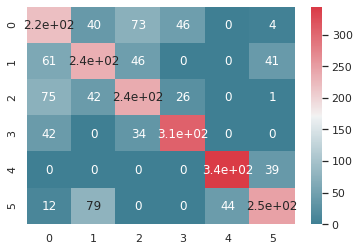

In [99]:
print_result(y_test, pred_knn_random)

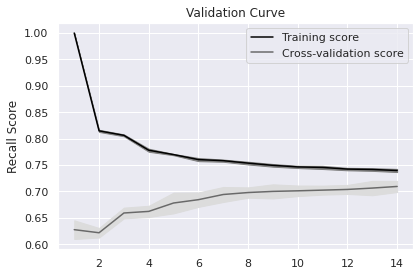

In [280]:
train_scores, valid_scores = validation_curve(knn_random, values, targets, "n_neighbors",
                                             param_range=params['n_neighbors'], cv=9, scoring="recall_macro")
# n_neighbors
plot_valid_train(train_scores, valid_scores, params['n_neighbors'])

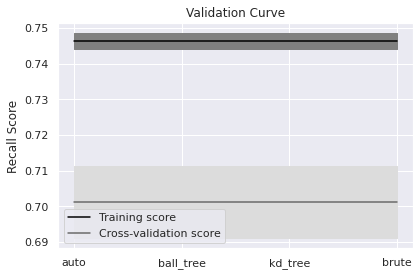

In [281]:
train_scores, valid_scores = validation_curve(knn_random, values, targets, "algorithm",
                                             param_range=params['algorithm'], cv=9, scoring="recall_macro")
# algorithm
plot_valid_train(train_scores, valid_scores, params['algorithm'])

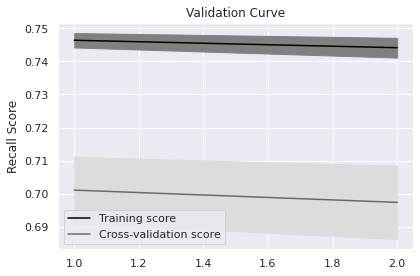

In [282]:
train_scores, valid_scores = validation_curve(knn_random, values, targets, "p",
                                             param_range=params['p'], cv=9, scoring="recall_macro")
# p
plot_valid_train(train_scores, valid_scores, params['p'])

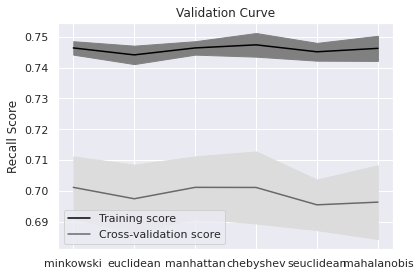

In [283]:

train_scores, valid_scores = validation_curve(knn_random, values, targets, "metric",
                                             param_range=params['metric'], cv=9, scoring="recall_macro")
# metric
plot_valid_train(train_scores, valid_scores, params['metric'])

На графиках также не видно явного переобучения модели, но можно отметить, что параметры p и algoritm не оказывают влияния на качество алгоритма.

## Grid search:

In [90]:
%%time
do_grid_search(model=knn, refit='recall_macro', params=params, x_train=x_train, y_train=y_train, x_test=x_test)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 824 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 3176 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 6692 tasks      | elapsed:   53.1s


Best params for recall_macro
{'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
CPU times: user 3.47 s, sys: 80.4 ms, total: 3.55 s
Wall time: 53.6 s


[Parallel(n_jobs=4)]: Done 6713 out of 6720 | elapsed:   53.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 6720 out of 6720 | elapsed:   53.5s finished


GridSearchCV параметры:

**{'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}**

Затраченное время:
- CPU times: user 2.55 s, sys: 69.5 ms, total: 2.62 s
- Wall time: 33.1 s

In [284]:
knn_grid = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=11, metric='chebyshev', algorithm='auto')
knn_grid.fit(x_train, y_train)
pred_knn_grid = knn_grid.predict(x_test)

score = cross_val_score(knn_grid, values, targets, cv=9, scoring='recall_macro')
print('Средняя оценка recall с настройкой гиперпараметров (GridSearchCV): ', np.mean(score))

Средняя оценка recall с настройкой гиперпараметров (GridSearchCV):  0.704780361757106


classification report: 
               precision    recall  f1-score   support

           0       0.53      0.56      0.54       383
           1       0.59      0.63      0.61       383
           2       0.62      0.60      0.61       383
           3       0.81      0.81      0.81       383
           4       0.91      0.89      0.90       383
           5       0.74      0.68      0.71       383

    accuracy                           0.69      2298
   macro avg       0.70      0.69      0.70      2298
weighted avg       0.70      0.69      0.70      2298

Матрица ошибок: 
 [[216  46  68  48   0   5]
 [ 62 241  39   0   0  41]
 [ 82  45 231  24   0   1]
 [ 39   0  34 310   0   0]
 [  0   0   0   0 339  44]
 [ 11  78   0   0  34 260]] 



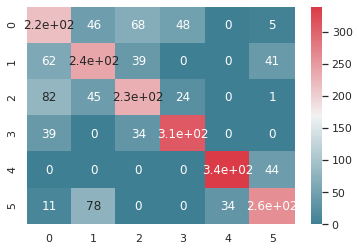

In [97]:
print_result(y_test, pred_knn_grid)

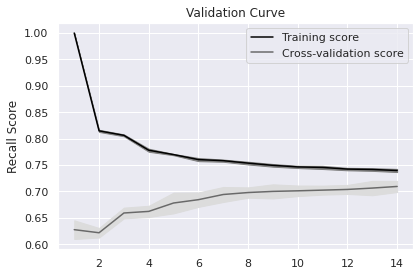

In [285]:
train_scores, valid_scores = validation_curve(knn_random, values, targets, "n_neighbors",
                                             param_range=params['n_neighbors'], cv=9, scoring="recall_macro")
# n_neighbors
plot_valid_train(train_scores, valid_scores, params['n_neighbors'])

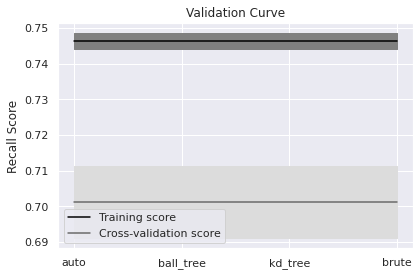

In [286]:
train_scores, valid_scores = validation_curve(knn_random, values, targets, "algorithm",
                                             param_range=params['algorithm'], cv=9, scoring="recall_macro")
# algorithm
plot_valid_train(train_scores, valid_scores, params['algorithm'])

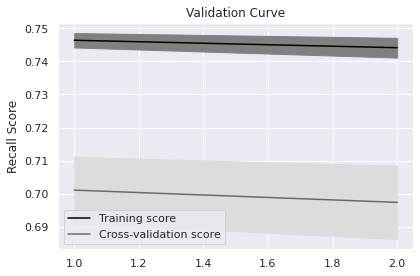

In [287]:
train_scores, valid_scores = validation_curve(knn_random, values, targets, "p",
                                             param_range=params['p'], cv=9, scoring="recall_macro")
# p
plot_valid_train(train_scores, valid_scores, params['p'])

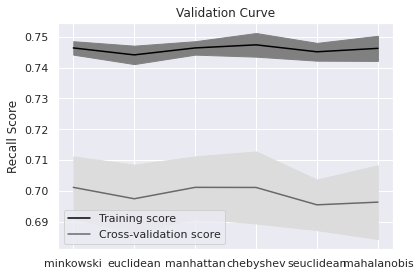

In [288]:
train_scores, valid_scores = validation_curve(knn_random, values, targets, "metric",
                                             param_range=params['metric'], cv=9, scoring="recall_macro")
# metric
plot_valid_train(train_scores, valid_scores, params['metric'])

Графики выглядят так же, как и в случае случайного поиска.

Переобучение не наблюдается.

# <center> Полученные результаты и их интерпретация: </center>

- Сначала сравним результаты, полученные classification report (рассмотрим recall).

**Дерево решений**: RandomSearchCV дал увеличение recall для всех классов за исключением четвертого класса (recall без гиперпараметров: 0.84, с гиперпараметрами: 0.79). GridSearchCV дал увелечение recall для кажого класса. Однако, время работы RandomSearchCV намного меньше, чем время работы GridSearchCV. Это связано с тем, что поиск по сетке тратит слишком много времени на оценку бесперспективных областей пространства гиперпараметров, так как он оценивает каждую отдельную комбинацию в сетке. Случайный поиск, напротив, лучше справляется с исследованием пространства поиска, поэтому обычно может найти хорошую комбинацию гиперпараметров за гораздо меньшее количество итераций.

**kNN**: Здесь также видим аналогичную ситуацию, только уже для трёх классов (второго, третьего, четвертого). И случайный поиск, и поиск по сетке уменьшили значение recall для третьего класса ( исходное 0.84, полученное - 0.81 в обоих случаях). Для четвертого класса значение recall в случае поиска по сетке не изменилось (0.91), в случае случайного поиска - уменьшилось (0.89). Для второго класса значение Recall в случае поиска по сетке не изменилось (без настройки 0.62, с настройкой 0.62), в случае случайного поиска - уменьшилось (0.61).

- Сравним результаты, полученные в результате оценки кросс-валидацией.

Для обоих алгоритмов также вычислялось среднее значение recall, и в каждом случае выделяется тенденция роста качества ( без настройки < настройка случайным поиском < настройка сеткой).


# <center> Выводы о плюсах и минусах используемых подходов: </center>

- Во-первых, поиск по сетке работает медленне случайного поиска. Так как оба метода поиска дают прирост качества (средняя оценка на кросс-валидации), то для первичной настройки гиперпараметров, возможно, лучше сначала пробовать случайный поиск из-за скорости работы. Если же не получается добиться желаемого качества, то можно использовать поиск по сетке.
- Также, случайный поиск хоть и не является "информативным" методом (то есть, он не полагается на прошлые результаты оценки), он обычно может находить лучшие значения, чем значения по умолчанию, и его легко запустить.
- Поиск по сетке работает медленнее, но даёт результат лучше, чем случайный поиск.
- Также важно отметить, что настройка гиперпараметров не всегда является хорошим решением для увеличения качества, потому что она может привести к переобучению. Использование настройки с учётом кросс-валидации должно минимизировать этот риск, но он все равно имеет место быть.
- В случае, когда случайный поиск или поиск по сетке не даёт желаемого значения точности, то можно использовать "информативные" методы, например, байесовскую оптимизацию гиперпараметров. В данном случае для решающих деревьев она дала лучшую настройку гиперпараметров (код приведён ниже).

# Байесовская оптимизация

Также можно сравнить поиск по сетке и случайный поиск с другим методом оптимизации, который является информативным (полагается на прошлые результаты) - оптимизация Байеса.

In [101]:
! pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=7d82fa0036dc515e611035bdf6a5410b8f0359285b13976f318d2bcec409cc98
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [262]:
def bayesian_optimization(dataset, function, parameters):
   X_train, y_train, X_test, y_test = dataset
   n_iterations = 30
   gp_params =  {"alpha": 1e-6}
   BO = BayesianOptimization(function, parameters, random_state=0)
   BO.maximize(n_iter=n_iterations, **gp_params)
   return BO.max

In [251]:
def dtree_optimization(cv_splits):
    def function(max_depth, min_samples_leaf, min_samples_split):
        return cross_val_score(
                DecisionTreeClassifier(random_state=42, 
                                       max_depth= int(max_depth), 
                                       min_samples_leaf=min_samples_leaf, 
                                       min_samples_split=min_samples_split), 
               X=x_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="recall_macro",
               n_jobs=-1).mean()

    parameters = {'max_depth': (1, 32), 
                'min_samples_split': (0.01, 0.1),
                'min_samples_leaf': (0.01, 0.1)}
    
    return function, parameters

In [263]:
def train(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 9
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = DecisionTreeClassifier(
             max_depth=int(max(params["max_depth"], 0)),
             min_samples_leaf=int(max(params["min_samples_leaf"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             random_state=42)

    model.fit(X_train, y_train)
    return model

In [253]:
function, parameters =  dtree_optimization(9)

In [264]:
model = train(X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test, function=function, parameters=parameters)

|   iter    |  target   | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------
|  1        |  0.6781   |  18.01    |  0.07437  |  0.06425  |
|  2        |  0.6844   |  17.89    |  0.04813  |  0.06813  |
|  3        |  0.6749   |  14.57    |  0.09026  |  0.09673  |
|  4        |  0.6749   |  12.89    |  0.08126  |  0.0576   |
|  5        |  0.6749   |  18.61    |  0.0933   |  0.01639  |
|  6        |  0.3329   |  1.0      |  0.01     |  0.01     |
|  7        |  0.6939   |  32.0     |  0.01     |  0.1      |
|  8        |  0.6909   |  27.09    |  0.01328  |  0.09541  |
|  9        |  0.7049   |  29.56    |  0.01072  |  0.02097  |
|  10       |  0.6913   |  8.84     |  0.01232  |  0.09553  |
|  11       |  0.6939   |  30.41    |  0.01     |  0.1      |
|  12       |  0.7084   |  23.56    |  0.01     |  0.01     |
|  13       |  0.6935   |  21.76    |  0.0104   |  0.0917   |
|  14       |  0.7084   |  10.12    |  0.01022  |  0.01292  |
|  15   

In [266]:
dtree_bo = DecisionTreeClassifier(max_depth= 6.587 , min_samples_leaf=0.01, min_samples_split=0.01, random_state=42)
score = cross_val_score(dtree_bo, data.drop('target_value', axis=1), data.target_value, cv=9, scoring='recall_macro')
print('Средняя оценка recall с байесовской настройкой гиперпараметров: ', np.mean(score))

Средняя оценка recall с байесовской настройкой гиперпараметров:  0.7073972741551401


Из недостатков - придется вручную проверить результат работы (выделение оптимального набора розовым цветом), так как он не всегда выделяет лучший результат.